In [2]:
import pandas as pd
import numpy as np
import re


In [3]:
file_path = r"C:\projectx work with Jesus\New results (doxycycline time course)\DIANN results"

df = pd.read_csv(f"{file_path}/filter_renamed_normalized_matrix.csv", index_col = 0)


In [33]:
pat = re.compile(r"^(?P<geno>[^_]+)_(?P<trt>[^_]+)_(?P<time>[^_]+)_(?P<rep>\d+)$")

rows = []
for c in df.columns:
    m = pat.match(str(c))
    if not m:
        continue
    rows.append((
        m.group("geno"),
        m.group("trt"),
        m.group("time"),
        int(m.group("rep")),
        c
    ))

meta = pd.DataFrame(rows, columns=["Cell_line","Treatment","Time","Rep","Col"])

In [34]:
long = (
    df.reset_index()
      .melt(id_vars="Genes", var_name="Col", value_name="Value")
      .merge(meta, on="Col")
)

# 每个 protein × Genotype × Treatment × Time 的均值
mean_tc = (
    long.groupby(["Genes","Cell_line","Treatment","Time"], observed=True)["Value"]
        .mean()
        .reset_index()
)


In [35]:
mean_tc

,Genes,Cell_line,Treatment,Time,Value
0,A1BG,CL2,DAPT,16d,0.721221
1,A1BG,CL2,DAPT,3d,-0.078841
2,A1BG,CL2,DAPT,4d,0.581274
3,A1BG,CL2,DAPT,8d,0.641950
4,A1BG,CL2,VEH,16d,0.027299
...,...,...,...,...,...
140027,ZZZ3,CL5,DAPT,8d,0.811028
140028,ZZZ3,CL5,VEH,16d,-0.072609
140029,ZZZ3,CL5,VEH,3d,-0.263534
140030,ZZZ3,CL5,VEH,4d,-0.172916


In [36]:
mean_tc["Group"] = mean_tc["Cell_line"] + "_" + mean_tc["Treatment"]

In [38]:
times = ["3d","4d","8d","16d"]

mat = (
    mean_tc
      .pivot_table(index="Genes", columns=["Group","Time"], values="Value")
)

# 只保留 HOM_VEH 和 HOM_DAPT
mat = mat.loc[:, ["CL2_VEH","CL2_DAPT"]]

# 确保时间顺序
mat = mat.reindex(columns=pd.MultiIndex.from_product(
    [["CL2_VEH","CL2_DAPT"], times]
))


# correlation analysis 

In [39]:
import numpy as np
import pandas as pd

def timecorr_between_groups(mean_tc, group1, group2, times=("3d","4d","8d","16d")):

    """
    mean_tc: DataFrame with columns [Genes, Genotype, Treatment, Time, Value, Group]
    group1, group2: e.g. "HOM_VEH", "HOM_DAPT"
    return: per-gene Pearson and Spearman time correlation between two groups
    """
    

    mat = (
        mean_tc
          .pivot_table(index="Genes", columns=["Group","Time"], values="Value")
    )

    mat = mat.loc[:, [group1, group2]]
    mat = mat.reindex(columns=pd.MultiIndex.from_product([[group1, group2], times]))

    def _corrs(row):
        a = row[group1].values
        b = row[group2].values
        if np.isnan(a).any() or np.isnan(b).any():
            return pd.Series([np.nan, np.nan])

        pearson = np.corrcoef(a, b)[0,1]

        # spearman via rank correlation (no scipy needed)
        ra = pd.Series(a).rank(method="average").values
        rb = pd.Series(b).rank(method="average").values
        spearman = np.corrcoef(ra, rb)[0,1]

        return pd.Series([pearson, spearman])

    out = mat.apply(_corrs, axis=1)
    out.columns = [
        f"{group1}_vs_{group2}_pearson",
        f"{group1}_vs_{group2}_spearman"
    ]

    return out


In [45]:
corr_df_CL2_CL5_VEH = timecorr_between_groups(
    mean_tc,
    group1="CL2_VEH",
    group2="CL5_VEH",
    times=("3d","4d","8d","16d")
)

corr_df_CL2_CL5_DAPT = timecorr_between_groups(
    mean_tc,
    group1="CL2_DAPT",
    group2="CL5_DAPT",
    times=("3d","4d","8d","16d")
)

corr_df_CL5_DAPT_VEH = timecorr_between_groups(
    mean_tc,
    group1="CL5_VEH",
    group2="CL5_DAPT",
    times=("3d","4d","8d","16d")
)

corr_df_CL2_DAPT_VEH = timecorr_between_groups(
    mean_tc,
    group1="CL2_VEH",
    group2="CL2_DAPT",
    times=("3d","4d","8d","16d")
)

In [76]:
corr_merged_inner = pd.concat(
    [
        corr_df_CL2_CL5_VEH,
        corr_df_CL2_CL5_DAPT,
        corr_df_CL5_DAPT_VEH,
        corr_df_CL2_DAPT_VEH,
    ],
    axis=1,
    join="inner"
)

corr_merged_inner

,CL2_VEH_vs_CL5_VEH_pearson,CL2_VEH_vs_CL5_VEH_spearman,CL2_DAPT_vs_CL5_DAPT_pearson,CL2_DAPT_vs_CL5_DAPT_spearman,CL5_VEH_vs_CL5_DAPT_pearson,CL5_VEH_vs_CL5_DAPT_spearman,CL2_VEH_vs_CL2_DAPT_pearson,CL2_VEH_vs_CL2_DAPT_spearman
Genes,,,,,,,,
A1BG,0.664723,0.8,-0.222058,-0.4,0.431727,0.6,-0.655837,-0.2
A2M,0.606580,0.4,-0.408220,-0.4,0.163053,-0.2,0.268540,0.2
AAAS,-0.748174,-0.8,-0.121111,0.2,0.042397,-0.2,0.712225,0.8
AACS,0.884933,0.4,-0.495223,-0.8,-0.152159,0.0,0.877915,0.4
AADAT,0.551701,0.4,0.953700,1.0,0.987003,1.0,0.741085,0.4
...,...,...,...,...,...,...,...,...
ZXDC,-0.812057,-0.4,-0.982509,-1.0,-0.565607,-0.8,0.117007,0.0
ZYG11B,0.781059,0.4,-0.665754,-0.8,0.861408,1.0,-0.910872,-0.8
ZYX,-0.931898,-0.4,0.477418,0.2,-0.590855,-0.4,0.947890,0.2


In [48]:
# corr_df_CL2_CL5_VEH 

In [106]:
import os 
import seaborn as sns
import matplotlib.pyplot as plt
# ---- Set global font once ----
plt.rcParams["font.family"] = "Arial"

def draw_violin(df, col):
    
    # drop missing values
    data = df[col].dropna()
    
    plt.figure(figsize=(4,6))
    
    sns.violinplot(
        y=data,
        inner="quartile",   # show median & quartiles
        linewidth=1.2,
        cut=0              # do not extend beyond data range
    )
    
    title = col.split("_pear")[0]
    plt.ylabel("Pearson correlation", fontsize=16)
    plt.title(title, fontsize=15)
    plt.tick_params(axis="y", labelsize=15)
    
    plt.tight_layout()
    
    save_file = os.path.join(out_path, f"{col}.svg")
    plt.savefig(save_file, dpi=600, bbox_inches="tight")
    plt.show()


In [ ]:
col = "CL2_VEH_vs_CL2_DAPT_pearson"
df = corr_df_CL2_DAPT_VEH.copy()

out_path = r"C:\projectx work with Jesus\New results (doxycycline time course)\figures"
draw_violin(df, col)

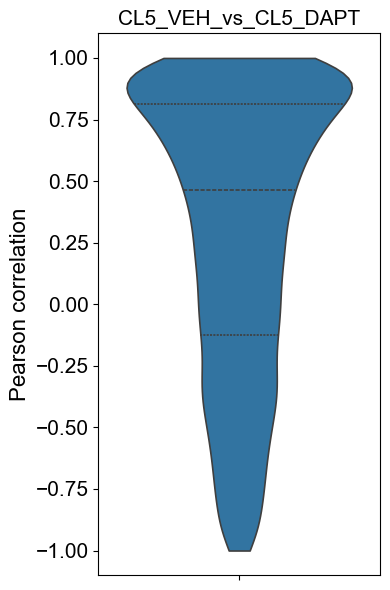

In [71]:
col = "CL5_VEH_vs_CL5_DAPT_pearson"
df = corr_df_CL5_DAPT_VEH.copy()

out_path = r"C:\projectx work with Jesus\New results (doxycycline time course)\figures"
draw_violin(df, col)

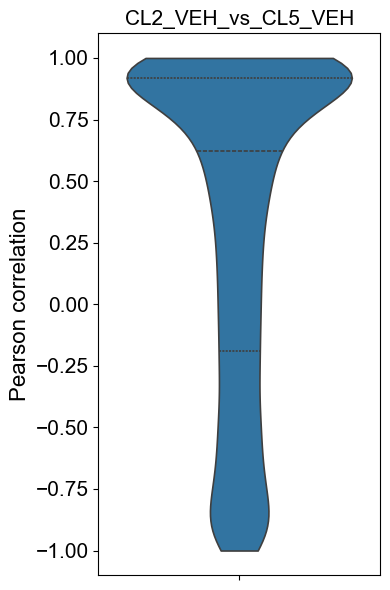

In [73]:
col = "CL2_VEH_vs_CL5_VEH_pearson"
df = corr_df_CL2_CL5_VEH.copy()

out_path = r"C:\projectx work with Jesus\New results (doxycycline time course)\figures"
draw_violin(df, col)

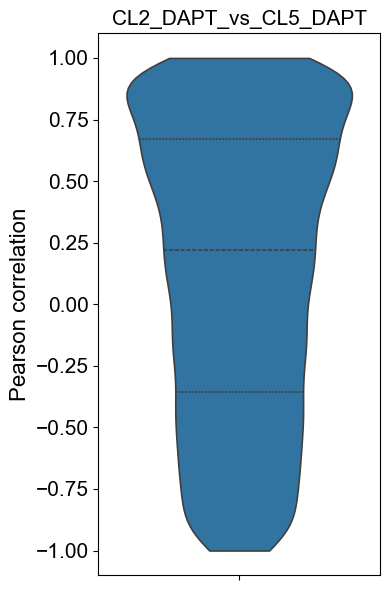

In [74]:
col = "CL2_DAPT_vs_CL5_DAPT_pearson"
df = corr_df_CL2_CL5_DAPT.copy()

out_path = r"C:\projectx work with Jesus\New results (doxycycline time course)\figures"
draw_violin(df, col)

In [97]:
cols = [
    "CL2_VEH_vs_CL2_DAPT_pearson",
    "CL5_VEH_vs_CL5_DAPT_pearson",
    "CL2_VEH_vs_CL5_VEH_pearson",
    "CL2_DAPT_vs_CL5_DAPT_pearson"
]

cols2 = [
    "CL2_VEH_vs_CL2_DAPT_spearman",
    "CL5_VEH_vs_CL5_DAPT_spearman",
    "CL2_VEH_vs_CL5_VEH_spearman",
    "CL2_DAPT_vs_CL5_DAPT_spearman"
]

In [102]:
plot_df = corr_merged_inner[cols].copy()

plot_long = plot_df.melt(
    value_vars=cols,
    var_name="Comparison",
    value_name="Pearson"
).dropna()


plot_df2 = corr_merged_inner[cols2].copy()

plot_long2 = plot_df2.melt(
    value_vars=cols2,
    var_name="Comparison",
    value_name="Spearman"
).dropna()

plot_long2

,Comparison,Spearman
0,CL2_VEH_vs_CL2_DAPT_spearman,-0.2
1,CL2_VEH_vs_CL2_DAPT_spearman,0.2
2,CL2_VEH_vs_CL2_DAPT_spearman,0.8
3,CL2_VEH_vs_CL2_DAPT_spearman,0.4
4,CL2_VEH_vs_CL2_DAPT_spearman,0.4
...,...,...
35003,CL2_DAPT_vs_CL5_DAPT_spearman,-1.0
35004,CL2_DAPT_vs_CL5_DAPT_spearman,-0.8
35005,CL2_DAPT_vs_CL5_DAPT_spearman,0.2
35006,CL2_DAPT_vs_CL5_DAPT_spearman,-0.4


C:\Users\jiangy5\AppData\Local\Temp\ipykernel_24352\1800930479.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
C:\Users\jiangy5\AppData\Local\Temp\ipykernel_24352\1800930479.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(nice_labels, rotation=30, ha="right", fontsize=15)


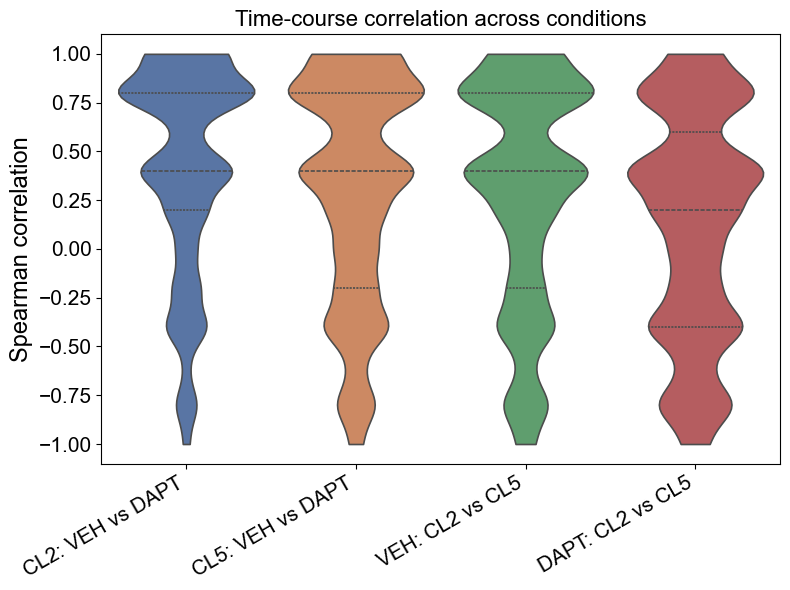

In [103]:
import seaborn as sns
import matplotlib.pyplot as plt

Comparison = [
    "CL2_VEH_vs_CL2_DAPT_spearman",
    "CL5_VEH_vs_CL5_DAPT_spearman",
    "CL2_VEH_vs_CL5_VEH_spearman",
    "CL2_DAPT_vs_CL5_DAPT_spearman"
]

nice_labels = [
    "CL2: VEH vs DAPT",
    "CL5: VEH vs DAPT",
    "VEH: CL2 vs CL5",
    "DAPT: CL2 vs CL5"
]

palette = {
    "CL2_VEH_vs_CL2_DAPT_spearman": "#4C72B0",   # blue
    "CL5_VEH_vs_CL5_DAPT_spearman": "#DD8452",   # orange
    "CL2_VEH_vs_CL5_VEH_spearman": "#55A868",    # green
    "CL2_DAPT_vs_CL5_DAPT_spearman": "#C44E52"   # red
}

plt.figure(figsize=(8,6))

ax = sns.violinplot(
    data=plot_long2,
    x="Comparison",
    y="Spearman",
    order=Comparison,     # 控制顺序
    inner="quartile",
    palette=palette, 
    cut=0,
    linewidth=1.2
)

ax.set_xticklabels(nice_labels, rotation=30, ha="right", fontsize=15)

plt.ylabel("Spearman correlation", fontsize=17)
plt.yticks(fontsize=15)
plt.xlabel("")
plt.title("Time-course correlation across conditions_spearman", fontsize=16)

plt.tight_layout()
plt.savefig(r"C:\projectx work with Jesus\New results (doxycycline time course)\figures\Time-course correlation across conditions_spearman.svg", dpi=600, bbox_inches="tight")
plt.show()

C:\Users\jiangy5\AppData\Local\Temp\ipykernel_24352\2520408914.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
C:\Users\jiangy5\AppData\Local\Temp\ipykernel_24352\2520408914.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(nice_labels, rotation=30, ha="right", fontsize=15)


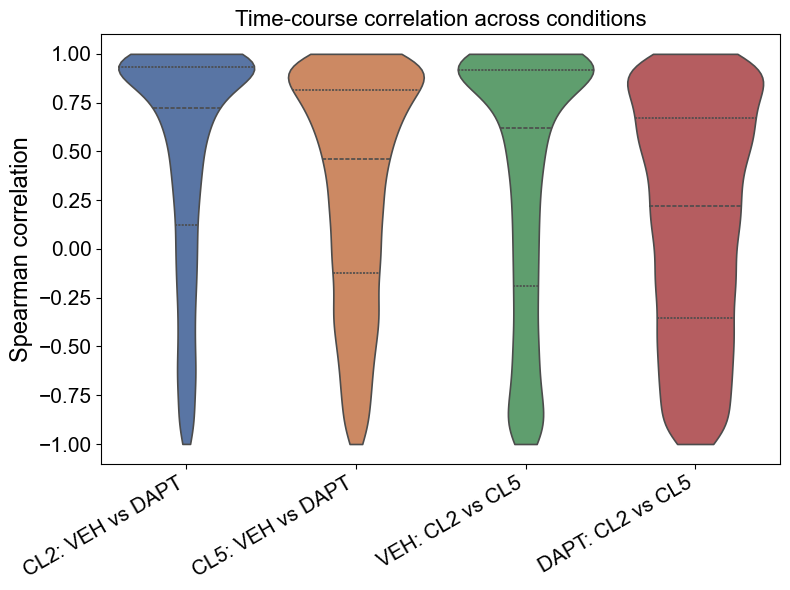

In [104]:
import seaborn as sns
import matplotlib.pyplot as plt

Comparison = [
    "CL2_VEH_vs_CL2_DAPT_pearson",
    "CL5_VEH_vs_CL5_DAPT_pearson",
    "CL2_VEH_vs_CL5_VEH_pearson",
    "CL2_DAPT_vs_CL5_DAPT_pearson"
]

nice_labels = [
    "CL2: VEH vs DAPT",
    "CL5: VEH vs DAPT",
    "VEH: CL2 vs CL5",
    "DAPT: CL2 vs CL5"
]

palette = {
    "CL2_VEH_vs_CL2_DAPT_pearson": "#4C72B0",   # blue
    "CL5_VEH_vs_CL5_DAPT_pearson": "#DD8452",   # orange
    "CL2_VEH_vs_CL5_VEH_pearson": "#55A868",    # green
    "CL2_DAPT_vs_CL5_DAPT_pearson": "#C44E52"   # red
}

plt.figure(figsize=(8,6))

ax = sns.violinplot(
    data=plot_long,
    x="Comparison",
    y="Pearson",
    order=Comparison,     # 控制顺序
    inner="quartile",
    palette=palette, 
    cut=0,
    linewidth=1.2
)

ax.set_xticklabels(nice_labels, rotation=30, ha="right", fontsize=15)

plt.ylabel("Spearman correlation", fontsize=17)
plt.yticks(fontsize=15)
plt.xlabel("")
plt.title("Time-course correlation across conditions", fontsize=16)

plt.tight_layout()
plt.savefig(r"C:\projectx work with Jesus\New results (doxycycline time course)\figures\Time-course correlation across conditions_pearson.svg", dpi=600, bbox_inches="tight")
plt.show()

# gene clustering 

In [105]:
corr_merged_inner

,CL2_VEH_vs_CL5_VEH_pearson,CL2_VEH_vs_CL5_VEH_spearman,CL2_DAPT_vs_CL5_DAPT_pearson,CL2_DAPT_vs_CL5_DAPT_spearman,CL5_VEH_vs_CL5_DAPT_pearson,CL5_VEH_vs_CL5_DAPT_spearman,CL2_VEH_vs_CL2_DAPT_pearson,CL2_VEH_vs_CL2_DAPT_spearman
Genes,,,,,,,,
A1BG,0.664723,0.8,-0.222058,-0.4,0.431727,0.6,-0.655837,-0.2
A2M,0.606580,0.4,-0.408220,-0.4,0.163053,-0.2,0.268540,0.2
AAAS,-0.748174,-0.8,-0.121111,0.2,0.042397,-0.2,0.712225,0.8
AACS,0.884933,0.4,-0.495223,-0.8,-0.152159,0.0,0.877915,0.4
AADAT,0.551701,0.4,0.953700,1.0,0.987003,1.0,0.741085,0.4
...,...,...,...,...,...,...,...,...
ZXDC,-0.812057,-0.4,-0.982509,-1.0,-0.565607,-0.8,0.117007,0.0
ZYG11B,0.781059,0.4,-0.665754,-0.8,0.861408,1.0,-0.910872,-0.8
ZYX,-0.931898,-0.4,0.477418,0.2,-0.590855,-0.4,0.947890,0.2
